# QF 627 Extras - Financial Analytics
## Lesson 2 | The Two Worlds of Statistical Modeling, Confounders, Colliders, and RCTs

> Hi, Team 👋 Thank you for opening the lecture note 🙂

<table style="width: 100%;">
  <tr>
    <td style="width: 25%; text-align: center; padding-right: 20px;">
      <img src="https://images.squarespace-cdn.com/content/v1/53f3eb3ce4b077de0318f4ea/1705649199392-2MVU89VL4DTZM4HCYC2B/thankyou_prof_roh.gif" alt="Prof. Roh" width="100%" height="auto">
    </td>
    <td style="vertical-align: top;">

> Tonight, we will first explore the differences between models for `explanation` and models for `prediction`. Understanding this distinction is crucial as it can significantly influence the modeling strategy you use. Without a clear understanding of the question you're asking, you might apply the wrong method, leading to incorrect conclusions from your data. This chapter will demonstrate the consequences of confusing these two types of questions.

> In modeling for explanation purposes (`b-hat` questions), the objective is to estimate the association between a predictor of interest and the outcome. Typically, there are a few key predictors, but numerous potential confounding variables that must be accounted for. The primary goal is to estimate the association while adjusting for these confounders. Sensitivity analyses are often conducted to check if the associations of interest remain stable across different sets of confounding variables.

> In modeling for prediction purposes (`y-hat` questions), the goal is to identify a model that best predicts the outcome. The focus isn't on the predictors per se, as long as they effectively predict the outcome. There is no concern about `confounding` or `predictors of interest`—all predictors are potential contributors to the outcome prediction. Detailed explanations of the predictors or the workings of the model are NOT necessary. The main objective is to develop a model with strong predictive capabilities and to accurately estimate an error rate from the data.

> After establishing a solid understanding of these two primary modeling types, we will dive into the implications of `confounders` and `colliders` in causal inference (modeling for explanatory purposes). You will also learn how to conduct `simulations`—an essential toolkit for real-world problem-solving in financial analytics—to create `synthetic data`.

> Next, we will discuss the gold standard of causal inference: `Randomized Controlled Trials` (`RCTs`). This section of the lecture notes will include a companion Python script and supplementary materials from our textbook, Causal Inference for the Brave and True.

> One key lesson for tonight will focus on the `decomposition of variance` that underpins modeling processes. This lesson will deepen your understanding of what regression truly involves.

> Let's embark on this informative journey together 🙂
    </td>
  </tr>
</table>

## DEPENDENCIES

In [1]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime
import re

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(2005)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

# Define our customized timer function

def countdown(Time):
    
    while Time:
        minutes, seconds = divmod(Time, 60)
        timer = "{:02d}:{:02d}".format(minutes, seconds)
        
        print(timer, end = "\r")
        time.sleep(1)
        Time -= 1
        
    print("Let us solve the problem above together :)")

## 👉 <a id = "top">Learning Pointers</a> 👈 

## [1. Two Worlds of Models](#p1)

> ### <font color = red> To model for explanation or for prediction, that is the question. </font>

## [2. Solving a Business/Policy Question in the Field](#p2)

> ### <font color = red> Air Pollution and Mortality in New York. </font>

## [3. Model for Explanation](#p3)

> ### <font color = red> The B-hat Problem </font>

## [4. Model for Prediction](#p4)

> ### <font color = red> The Y-hat Problem </font>

## [5. Confounders vs. Colliders](#p5)

> ### <font color = red> Simulation with Synthetic Data </font>

## [6. Randomized Controlled Trials](#p6)

> ### <font color = red> The Golden Standard for Causal Inference: RCTs </font>

## [7. What We Learned](#p7)

> ### <font color = red> Revisiting Learning Pointers </font>


## <a id = "p1">1. </a> <font color = "green"> Two Worlds of Models </font>  [back to table of contents](#top)

### Analytics Contexts

> `To model for explanation or for prediction, that is the question.` 

> Understanding the difference between answering a model for explanation question versus a model for prediction question is important, as it can greatly impact the modeling strategy used. If you do not clearly understand the type of question you are asking, you may use the wrong modeling approach and arrive at incorrect conclusions from your data. The purpose of this chapter is to demonstrate the consequences of confusing one question for another.

### The key points to remember are:

- For model for ***explanation*** questions, the goal is to estimate the association between a predictor of interest and the outcome. Typically, there are a few predictors of interest (or just one), but many potential confounding variables to consider. The main objective of modeling is to estimate the association while adjusting for any potential confounding factors. Sensitivity analyses are often performed to determine if the associations of interest are robust to different sets of confounding variables.
<br>

- For model for ***prediction*** questions, the goal is to identify a model that best predicts the outcome. There is no prior emphasis on the predictors, so long as they are effective at predicting the outcome. There is no concept of "confounding" or "predictors of interest" as all predictors have the potential to be useful for predicting the outcome. Additionally, the details of "how the model works" or a detailed explanation of the predictors are not necessary. The main objective is to develop a model with good prediction ability and estimate a reasonable error rate from the data.

## <a id = "p2">2.</a>  <font color = "green"> Solving a Business/Policy Question in the Field: Air Pollution and Mortality in New York. </font>  [back to table of contents](#top)

> Our analysis will illustrate how different types of questions and corresponding modeling approaches can result in different conclusions. The data used is air pollution and mortality data for New York City.

In [2]:
# build your customized function to solve the problem

def read_dropbox(url):
    if "?dl=0" in url:
        return url.replace("?dl=0", "?raw=1")
    return url

#### IMPORT

In [3]:
data =\
    pd \
    .read_csv(read_dropbox("https://www.dropbox.com/s/yxqnrlp9z1ify2p/new_york.csv?dl=0")
              )

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20820 entries, 0 to 20819
Columns: 114 entries, city to dow
dtypes: float64(94), int64(16), object(4)
memory usage: 18.1+ MB


In [5]:
data.describe()

,alldeath,accident,copd,cvd,death,Inf,pne_inf,pneu,resp,suicide,...,cotmean,cotmean2,con,comax1,comax2,comax3,comax4,comax5,rmtmpd,rmdptp
count,20820.000000,20820.000000,20820.000000,20820.000000,20820.000000,20820.000000,20820.000000,20820.000000,20820.000000,20820.000000,...,20811.000000,20811.000000,20820.000000,20811.000000,20811.000000,20811.000000,20811.000000,20808.000000,20811.000000,20811.000000
mean,64.460423,1.822622,1.723583,29.418252,60.890682,0.005908,2.808405,2.802498,4.531988,0.463737,...,-14.772740,1493.333973,5.715706,5074.873865,4505.809428,4189.808274,3962.361251,3789.158016,55.184582,42.814142
std,29.364291,2.348272,1.597771,21.597851,27.830558,0.077880,2.956371,2.948587,3.933667,0.839935,...,396.653766,753.670578,1.024937,3405.782399,2909.388336,2642.879405,2451.004242,2304.687666,16.408586,17.443515
min,10.000000,0.000000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2013.449611,245.833333,0.000000,400.000000,200.000000,0.000000,0.000000,0.000000,8.750000,-4.402778
25%,40.000000,0.000000,1.000000,13.000000,37.000000,0.000000,1.000000,1.000000,2.000000,0.000000,...,-230.343346,912.651515,5.000000,2500.000000,2200.000000,2100.000000,2000.000000,2000.000000,41.833333,29.104167
50%,62.000000,1.000000,1.000000,18.000000,54.000000,0.000000,2.000000,2.000000,3.000000,0.000000,...,-57.843446,1335.416667,6.000000,4300.000000,3900.000000,3600.000000,3500.000000,3300.000000,55.222222,42.979167
75%,87.000000,3.000000,3.000000,51.000000,85.000000,0.000000,4.000000,4.000000,7.000000,1.000000,...,144.606851,1882.291667,6.000000,6800.000000,6100.000000,5600.000000,5300.000000,5100.000000,70.333333,58.166667
max,1304.000000,168.000000,13.000000,127.000000,182.000000,2.000000,23.000000,23.000000,27.000000,6.000000,...,3024.501660,5227.717391,8.000000,37400.000000,31500.000000,24800.000000,24800.000000,20400.000000,90.666667,74.770833


In [6]:
data.columns

Index(['city', 'alldeath', 'accident', 'copd', 'cvd', 'death', 'Inf',
       'pne_inf', 'pneu', 'resp',
       ...
       'cotmean2', 'con', 'comax1', 'comax2', 'comax3', 'comax4', 'comax5',
       'rmtmpd', 'rmdptp', 'dow'],
      dtype='object', length=114)

In [7]:
data.shape

(20820, 114)

In [8]:
data.head(3)

,city,alldeath,accident,copd,cvd,death,Inf,pne_inf,pneu,resp,...,cotmean2,con,comax1,comax2,comax3,comax4,comax5,rmtmpd,rmdptp,dow
0,ny,93,10,3,22,73,0,3,3,6,...,2088.352273,6,8100.0,6800.0,6000.0,5200.0,5100.0,NaN,NaN,Thursday
1,ny,77,4,4,20,68,0,1,1,5,...,2049.031385,6,9500.0,9000.0,8800.0,8400.0,8000.0,NaN,NaN,Friday
2,ny,64,5,0,17,56,0,3,3,3,...,1875.815217,6,8400.0,7700.0,6700.0,6200.0,6000.0,NaN,NaN,Saturday


#### WRANGLE

In [9]:
subset_DF =\
data[["date"]].tail()

In [10]:
subset_DF

,date
20815,2005-12-27
20816,2005-12-28
20817,2005-12-29
20818,2005-12-30
20819,2005-12-31


In [11]:
data[["death"]]

,death
0,73
1,68
2,56
3,55
4,60
...,...
20815,92
20816,79
20817,107
20818,98


In [12]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [13]:
subset_DF =\
(
 data
 [["date", "death"]]
 .loc[data["date"] >= "2001-01-01"]
 .groupby("date")
 .sum()
 .reset_index()
)

In [14]:
subset_DF

,date,death
0,2001-01-01,186
1,2001-01-02,225
2,2001-01-03,202
3,2001-01-04,186
4,2001-01-05,226
...,...,...
1821,2005-12-27,162
1822,2005-12-28,152
1823,2005-12-29,176
1824,2005-12-30,163


In [15]:
(data
 .columns
 .to_frame()
)

,0
city,city
alldeath,alldeath
accident,accident
copd,copd
cvd,cvd
...,...
comax4,comax4
comax5,comax5
rmtmpd,rmtmpd
rmdptp,rmdptp


In [16]:
exposure =\
(    data 
     .drop(["death"],
           axis = 1)
     .loc[(data["agecat"] == "under65") & (data["date"] >= "2001-01-01")                 
         ]
)

In [17]:
exposure

,city,alldeath,accident,copd,cvd,Inf,pne_inf,pneu,resp,suicide,...,cotmean2,con,comax1,comax2,comax3,comax4,comax5,rmtmpd,rmdptp,dow
5114,ny,67,7,2,13,0,0,0,2,2,...,730.000000,7,1800.0,1700.0,1600.0,1600.0,1600.0,26.888889,17.444444,Monday
5115,ny,64,5,1,13,0,1,1,2,0,...,934.762846,7,2900.0,2500.0,2300.0,2200.0,2200.0,28.111111,17.955556,Tuesday
5116,ny,55,1,1,12,0,2,2,3,1,...,1207.500000,7,2600.0,2400.0,2400.0,2300.0,2300.0,26.333333,13.655556,Wednesday
5117,ny,55,4,4,10,0,0,0,4,2,...,1249.206192,7,2600.0,2500.0,2500.0,2300.0,2200.0,25.444444,13.355556,Thursday
5118,ny,64,2,2,21,0,0,0,2,0,...,1350.000000,6,3000.0,2900.0,2500.0,2400.0,2300.0,25.888889,15.077778,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6935,ny,47,2,0,13,0,1,1,1,2,...,494.507576,4,1400.0,900.0,900.0,900.0,800.0,46.000000,36.444444,Tuesday
6936,ny,48,2,0,11,0,0,0,0,0,...,704.464286,4,1600.0,1500.0,1300.0,1300.0,1300.0,43.555556,35.522222,Wednesday
6937,ny,45,2,1,10,0,0,0,1,2,...,783.333333,4,2200.0,2200.0,1800.0,1700.0,1600.0,42.333333,33.644444,Thursday
6938,ny,47,4,2,16,0,1,1,3,1,...,533.333333,4,1100.0,1100.0,1000.0,800.0,800.0,43.111111,35.566667,Friday


In [18]:
data_for_analysis =\
(    pd
     .merge(subset_DF, exposure,
            on = "date")
)

In [19]:
print(subset_DF.shape);print(exposure.shape);print(data_for_analysis.shape)

(1826, 2)
(1826, 113)
(1826, 114)


In [20]:
data_for_analysis.dtypes

date         object
death         int64
city         object
alldeath      int64
accident      int64
             ...   
comax4      float64
comax5      float64
rmtmpd      float64
rmdptp      float64
dow          object
Length: 114, dtype: object

In [21]:
data_for_analysis \
    .date

0       2001-01-01
1       2001-01-02
2       2001-01-03
3       2001-01-04
4       2001-01-05
           ...    
1821    2005-12-27
1822    2005-12-28
1823    2005-12-29
1824    2005-12-30
1825    2005-12-31
Name: date, Length: 1826, dtype: object

In [22]:
data_for_analysis["date"] =\
(
    pd
    .to_datetime(data_for_analysis["date"]
                )
)

data_for_analysis \
    .dtypes

date        datetime64[ns]
death                int64
city                object
alldeath             int64
accident             int64
                 ...      
comax4             float64
comax5             float64
rmtmpd             float64
rmdptp             float64
dow                 object
Length: 114, dtype: object

In [23]:
data_for_analysis["season"] =\
(    data_for_analysis
     ["date"]
     .dt
     .quarter
)

(
    data_for_analysis 
    .season
    .unique()
)

array([1, 2, 3, 4], dtype=int32)

In [24]:
data_for_analysis["season"] =\
(
    data_for_analysis
    ["season"]
    .astype("category")
)

data_for_analysis \
    .season

0       1
1       1
2       1
3       1
4       1
       ..
1821    4
1822    4
1823    4
1824    4
1825    4
Name: season, Length: 1826, dtype: category
Categories (4, int32): [1, 2, 3, 4]

In [25]:
data_for_analysis["dow"] =\
(
    data_for_analysis
    ["date"] 
    .dt
    .weekday
)

In [26]:
data_for_analysis \
    .dow \
    .unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

#### VISUALIZE

> Let's visualize the daily mortality data from all causes for the years 2001 to 2005.

In [27]:
data_for_analysis \
    .columns \
    .to_frame()

,0
date,date
death,death
city,city
alldeath,alldeath
accident,accident
...,...
comax5,comax5
rmtmpd,rmtmpd
rmdptp,rmdptp
dow,dow


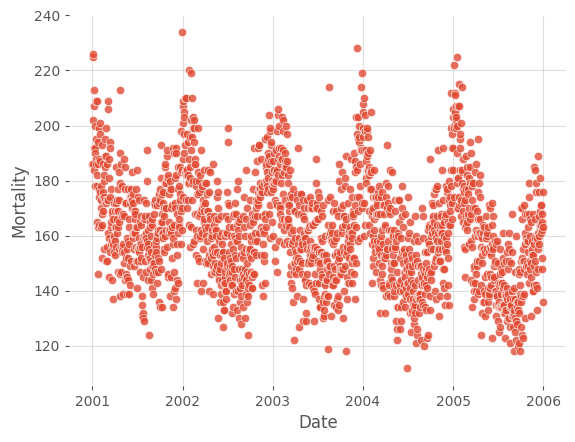

In [28]:
sns \
    .scatterplot(x = "date",
                 y = "death",
                 data = data_for_analysis,
                 alpha = 0.80)

plt \
    .xlabel("Date")

plt \
    .ylabel("Mortality")

plt \
    .show()

> Next, let's visualize a plot of the 24-hour average levels of particulate matter with aerodynamic diameter less than or equal to 10 microns (PM10).

In [29]:
data_for_analysis =\
    data_for_analysis \
    .rename(columns = {"no2tmean": "no2",
                       "pm10tmean": "pm10"}
           )

In [30]:
pm10_array =\
(
    np
    .array(data_for_analysis["pm10"]
           .values)
)

In [31]:
type(pm10_array)

numpy.ndarray

In [32]:
data_for_analysis["date"].values

array(['2001-01-01T00:00:00.000000000', '2001-01-02T00:00:00.000000000',
       '2001-01-03T00:00:00.000000000', ...,
       '2005-12-29T00:00:00.000000000', '2005-12-30T00:00:00.000000000',
       '2005-12-31T00:00:00.000000000'],
      shape=(1826,), dtype='datetime64[ns]')

In [33]:
date_array =\
(
    np
    .array(data_for_analysis["date"]
           .values)
)

In [34]:
date_array

array(['2001-01-01T00:00:00.000000000', '2001-01-02T00:00:00.000000000',
       '2001-01-03T00:00:00.000000000', ...,
       '2005-12-29T00:00:00.000000000', '2005-12-30T00:00:00.000000000',
       '2005-12-31T00:00:00.000000000'],
      shape=(1826,), dtype='datetime64[ns]')

In [35]:
data_for_analysis[["pm10"]]

,pm10
0,-11.303571
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1821,NaN
1822,NaN
1823,NaN
1824,NaN


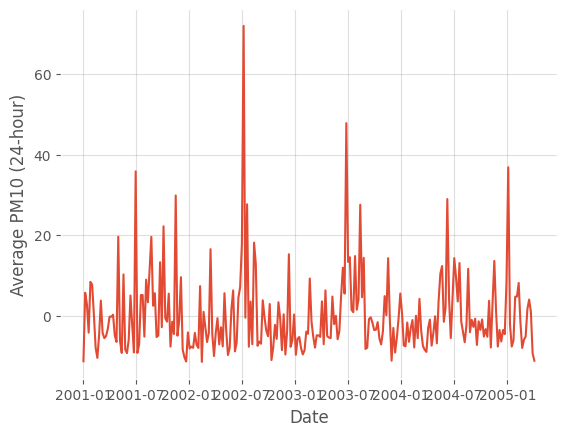

In [36]:
sns \
    .lineplot(x = "date",
              y = "pm10",
              data = data_for_analysis)

plt \
    .ylabel("Average PM10 (24-hour)")

plt \
    .xlabel("Date")

plt \
    .show()

> Note that there are fewer points on the PM10 plot compared to the mortality data plot. This is because PM10 is not measured every day. Additionally, note that there are negative values in the PM10 plot - this is due to the PM10 data being mean-subtracted. In general, negative values of PM10 are not possible.

## <a id = "p3">3.</a>  <font color = "green"> Model for Explanation </font>  [back to table of contents](#top)

> The first step we will take is to determine if there is a correlation between the daily 24-hour average PM10 levels and daily mortality. This is an inference question, and we aim to estimate the association. Additionally, we must consider potential confounding variables while addressing this question.

> We will start by analyzing the bivariate association between PM10 and mortality, using a scatterplot of the two variables. The plot does not show a significant relationship, and the results from a linear regression model of the log of daily mortality and PM10 support this observation.

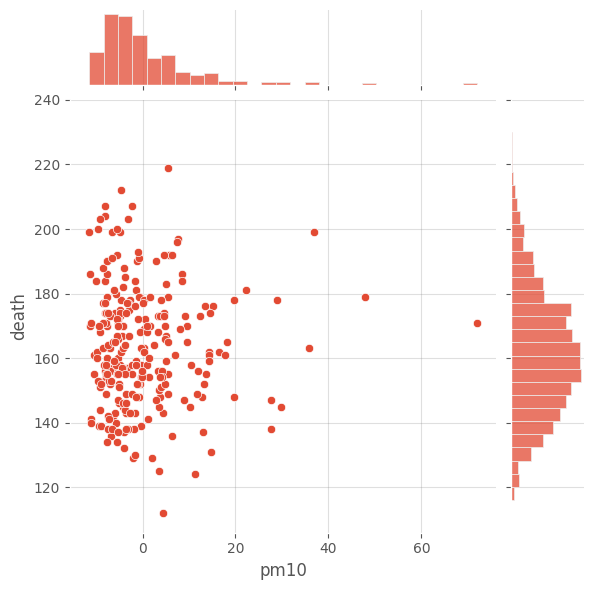

In [37]:
sns \
    .jointplot(x = "pm10",
               y = "death",
               data = data_for_analysis)

plt.show()

In [38]:
import statsmodels.formula.api as smf

In [39]:
regression_0 =\
(
    smf
    .ols("np.log(death) ~ pm10",
         data = data_for_analysis)
    .fit()
)

In [40]:
(regression_0
    .summary()
    .tables[1]
)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.0888,0.007,733.751,0.000,5.075,5.103
pm10,4.033e-05,0.001,0.058,0.954,-0.001,0.001


> In the table of coefficients, the PM10 coefficient is small and has a large standard error, implying that the estimate of the association is zero. However, both PM10 and daily mortality are influenced by season. Mortality is typically higher in winter and lower in summer, while PM10 shows the opposite pattern, being higher in summer and lower in winter. As season affects both PM10 and mortality, it can be considered a confounder and must be adjusted for in the model.

In [41]:
regression_1 =\
(
    smf
    .ols("np.log(death) ~ pm10 + season",
         data = data_for_analysis)
    .fit()
)    

In [42]:
regression_1 \
    .summary() \
    .tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1665,0.011,458.715,0.000,5.144,5.189
season[T.2],-0.1093,0.017,-6.547,0.000,-0.142,-0.076
season[T.3],-0.1555,0.017,-9.162,0.000,-0.189,-0.122
season[T.4],-0.0603,0.017,-3.608,0.000,-0.093,-0.027
pm10,0.0015,0.001,2.435,0.016,0.000,0.003


> In the second model, we include PM10 and season as a categorical variable with four levels. The PM10 coefficient is now larger, and the t-value suggests a strong association. This result is due to Simpson's Paradox, where the overall relationship between PM10 and mortality is null, but after considering the seasonal variation in both variables, the association becomes positive.

In [43]:
data_for_analysis[["date"]]

,date
0,2001-01-01
1,2001-01-02
2,2001-01-03
3,2001-01-04
4,2001-01-05
...,...
1821,2005-12-27
1822,2005-12-28
1823,2005-12-29
1824,2005-12-30


In [44]:
# This is what you do when dealing with date in regression

data_for_analysis["date"] =\
(    data_for_analysis
     ["date"]
     .astype(int)
     /
     10
     **
     9
)

In [45]:
data_for_analysis.date

0       9.783072e+08
1       9.783936e+08
2       9.784800e+08
3       9.785664e+08
4       9.786528e+08
            ...     
1821    1.135642e+09
1822    1.135728e+09
1823    1.135814e+09
1824    1.135901e+09
1825    1.135987e+09
Name: date, Length: 1826, dtype: float64

In [46]:
regression_2 =\
(
    smf
    .ols("np.log(death) ~ pm10 + season + date + tmpd + dptp",
         data = data_for_analysis) 
    .fit()
)

regression_2 \
    .summary() \
    .tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.6207,0.165,34.124,0.000,5.296,5.945
season[T.2],-0.0581,0.023,-2.525,0.012,-0.103,-0.013
season[T.3],-0.0766,0.029,-2.636,0.009,-0.134,-0.019
season[T.4],-0.0315,0.018,-1.721,0.086,-0.068,0.005
pm10,0.0024,0.001,3.600,0.000,0.001,0.004
date,-3.454e-10,1.52e-10,-2.269,0.024,-6.45e-10,-4.56e-11
tmpd,-0.0030,0.001,-2.297,0.022,-0.005,-0.000
dptp,0.0007,0.001,0.660,0.510,-0.001,0.003


> Temperature (`tmpd`) and dew point temperature (`dptp`) are additional weather variables that may impact both PM10 formation and mortality. Thus, we include these variables, along with the date, in the third model. The PM10 coefficient increases again, indicating a continued association between PM10 and mortality.

In [47]:
regression_3 =\
(
    smf 
    .ols("np.log(death) ~ pm10 + season + date + tmpd + dptp + no2",
         data = data_for_analysis)
    .fit()
)

regression_3 \
    .summary() \
    .tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.6138,0.164,34.147,0.000,5.290,5.938
season[T.2],-0.0514,0.023,-2.200,0.029,-0.097,-0.005
season[T.3],-0.0657,0.030,-2.197,0.029,-0.125,-0.007
season[T.4],-0.0275,0.018,-1.487,0.138,-0.064,0.009
pm10,0.0017,0.001,2.221,0.027,0.000,0.003
date,-3.442e-10,1.52e-10,-2.266,0.024,-6.43e-10,-4.5e-11
tmpd,-0.0030,0.001,-2.309,0.022,-0.005,-0.000
dptp,0.0007,0.001,0.681,0.497,-0.001,0.003
no2,0.0013,0.001,1.468,0.143,-0.000,0.003


In [48]:
(regression_3 
    .params # returns b (unstandardized regression coeffecients)
    ["pm10"] # returns regression coefficient for pm10
    .round(3)
)

np.float64(0.002)

In [49]:
(
    regression_3
    .conf_int()
    .loc["pm10"]
)

0    0.000197
1    0.003287
Name: pm10, dtype: float64

> Another class of confounding variables is other pollutants, such as NO2, which shares some sources with PM10 and has been linked to mortality. The final model includes NO2, and the results show that the NO2 coefficient is similar in magnitude to the PM10 coefficient, but with a smaller t-value. The PM10 coefficient remains statistically significant, although its magnitude decreases.

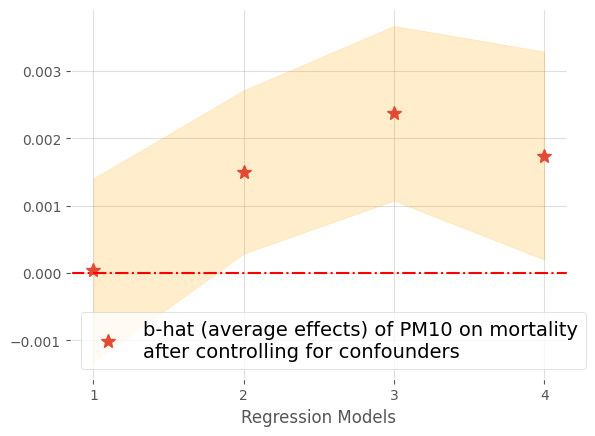

In [50]:
# Let's build a plot to compare the above four regression models

# point estimation of the effects within our available data

effects_of_pm10_within_data =\
(    
    np
    .array([regression_0.params["pm10"],
            regression_1.params["pm10"],
            regression_2.params["pm10"],
            regression_3.params["pm10"]
           ]
          )

)

# take into account confidence intervals (uncertainty) in estimation above

effects_of_pm10_out_of_data =\
(
    np
    .array([regression_0.conf_int().loc["pm10"],
            regression_1.conf_int().loc["pm10"],
            regression_2.conf_int().loc["pm10"],
            regression_3.conf_int().loc["pm10"]
           ]
          )
)

# four regression models

regression_models =\
    np \
    .arange(1, 5)

# Let's visualize

plt \
    .plot(regression_models,
          effects_of_pm10_within_data,
          "*",
          markersize = 10,
          label = "b-hat (average effects) of PM10 on mortality\nafter controlling for confounders"
          )

plt \
    .fill_between(regression_models,
                  effects_of_pm10_out_of_data[ : , 0],
                  effects_of_pm10_out_of_data[ : , 1],
                  color = "orange",
                  alpha = 0.20)

# setting a marker for NULL effects

plt \
    .axhline(0,
             color = "red",
             linestyle = "-.")

# ticks for each model

plt \
    .xticks(regression_models,
            regression_models)

# add labels for your information

plt \
    .xlabel("Regression Models")

plt.legend()

plt.show()

> A plot of the PM10 coefficient from all four models demonstrates a positive association between PM10 and mortality in Models 2-4, with a small effect size. It is essential to consider the impact of the small effect size, as everyone in New York City breathes and even a small effect can have a significant impact. The appropriate course of action will depend on the ultimate goal and is beyond the scope of this discussion.

## <a id = "p4">4.</a>  <font color = "green"> Model for Prediction </font>  [back to table of contents](#top)

> An alternative strategy we could have adopted is asking, "What best predicts mortality in New York City?" Since this is a prediction question, we can use available data to construct a model. In this case, we'll utilize the random forests modeling technique, a machine learning method that is effective when there are many predictors. One of the outputs we can obtain from the random forest method is a measure of variable importance, which roughly indicates how crucial a particular variable is in enhancing the prediction accuracy of the model.

> The following is a variable importance plot generated after fitting a random forest model. Larger values on the x-axis represent higher importance.

In [51]:
data_without_missing_values =\
    data_for_analysis \
    .dropna() # list-wise deletion

In [52]:
data_for_analysis.shape

(1826, 115)

In [53]:
data_without_missing_values.shape

(151, 115)

In [54]:
# Machine Learning for Prediction

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [56]:
Xs =\
    data_without_missing_values[["date",
                                 "season",
                                 "no2",
                                 "dptp",
                                 "o3tmean",
                                 "pm10",
                                 "tmpd"]
                               ]

Y = data_without_missing_values["death"]

In [57]:
# Step 1: Data Split

X_train, X_test, Y_train, Y_test =\
    train_test_split(Xs, Y,
                     test_size = 0.20,
                     random_state = 240423)

In [58]:
# Step 3: Model Specification (with Random Forest)

rf =\
    RandomForestRegressor(n_estimators = 100,
                          random_state = 240423)

rf \
    .fit(X_train, Y_train)

RandomForestRegressor(random_state=240423)

In [59]:
Y_hat =\
    rf \
    .predict(X_test)
                                                            # Actual Y vs. Predicted Y 
print("Model Performance based on MSE: %.1f" % mean_squared_error(Y_test, Y_hat)
     )

Model Performance based on MSE: 192.2


### Feature Importance

In [60]:
# How to access feature importance in algorithm
rf \
    .feature_importances_

array([0.113, 0.017, 0.152, 0.161, 0.112, 0.094, 0.35 ])

In [61]:
Xs

,date,season,no2,dptp,o3tmean,pm10,tmpd
522,1.023408e+09,2,-11.888542,53.166667,6.643837,-8.849769,62.333333
528,1.023926e+09,2,-9.464918,54.733333,-4.692630,-6.711598,61.666667
534,1.024445e+09,2,17.677537,59.866667,5.000090,4.461802,71.333333
540,1.024963e+09,2,6.879710,60.866667,13.367200,7.086800,78.333333
546,1.025482e+09,3,6.889079,64.633333,25.230881,17.766239,80.333333
...,...,...,...,...,...,...,...
1434,1.102205e+09,4,-0.618634,30.633333,-8.918673,-3.542251,46.666667
1440,1.102723e+09,4,-3.214733,42.833333,-15.179999,-6.403284,47.666667
1446,1.103242e+09,4,2.234568,19.966667,-10.721559,-3.541585,39.000000
1452,1.103760e+09,4,2.157841,47.400000,-5.735633,-4.576011,50.333333


Text(0.5, 0, 'Feature Importance')

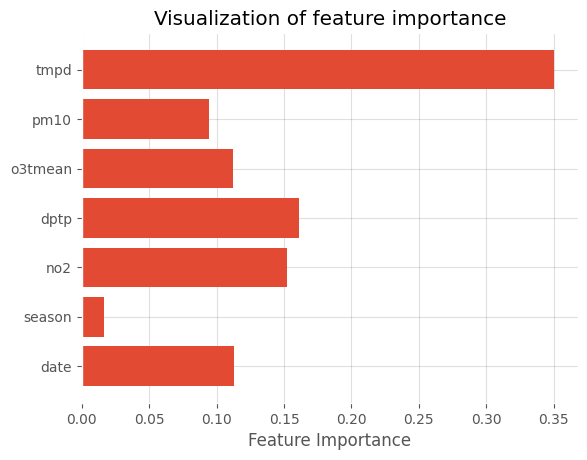

In [62]:
plt \
    .barh(Xs.columns,
          rf.feature_importances_)

plt.title("Visualization of feature importance")

plt.xlabel("Feature Importance")

> As seen in the plot, the variable pm10 has a low importance, as it doesn't contribute much to predicting mortality. This aligns with our observation from the previous section that the effect size was small, meaning it didn't explain much variability in mortality. Predictors like temperature and dew point temperature are more helpful in predicting daily mortality, with even NO2 being a better predictor than PM10.

> However, just because PM10 isn't a strong predictor of mortality, it doesn't imply that it has no association with mortality. Given the limitations that come with developing a prediction model, PM10 is not a priority among the predictors we would consider including - it's not feasible to include every predictor.

> In any business analytics task, it's crucial to determine beforehand whether you're seeking a model for explanation or prediction. This decision can shape the entire modeling strategy. In this example, if we had taken a prediction approach, we might have wrongly assumed that PM10 was not related to mortality. However, the inferential approach revealed a statistically significant association with mortality. Properly framing the question and applying the appropriate modeling approach can significantly impact the conclusions drawn from the data.

## <a id = "p5">5. </a> <font color = "green"> Confounders vs. Colliders </font>  [back to table of contents](#top)

### Analytics Contexts

> One of the very first things you might hear in field practice is the concept of controlling variables. Controlling for variables is of crucial importance during the modeling process for explanation (b-hat problem solving). Before diving into learning causal inference with econometric methods and techniques, it is essential to understand what it means to control variables, why it is important, and under which circumstances you should not control variables.

### Problem of Omitted Variable

> When a variable that affects your dependent variable (y) is missing from the model, and at the same time it is correlated with your independent variable (x), you will face omitted variable bias. We call that variable z.

> The problem of omitted variable is in play when you consider the causal relationship between x and y variables. It is referred to as `endogenous.`

In [63]:
# Team, we are building synthetic (simulated) data by ourselves.

np \
    .random \
    .seed(240423)

N = 4000

x =\
(
    np
    .random
    .normal(size = N)
)

# Let's set TRUE average treatment effects (ATE) of X at 0.40

y = 0.40 * x + np.random.normal(size = N)

In [64]:
%whos

Variable                      Type                        Data/Info
-------------------------------------------------------------------
N                             int                         4000
RandomForestRegressor         ABCMeta                     <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
X_test                        DataFrame                                 date season<...>0000  \n1374  55.666667  
X_train                       DataFrame                                 date season<...>n\n[120 rows x 7 columns]
Xs                            DataFrame                                 date season<...>n\n[151 rows x 7 columns]
Y                             Series                      522     139\n528     136\<...>Length: 151, dtype: int64
Y_hat                         ndarray                     31: 31 elems, type `float64`, 248 bytes
Y_test                        Series                      1230    158\n1320    149\<...>Name: death, dtype: int64
Y_train            

In [65]:
data =\
    {"x": x,
     "y": y}

In [66]:
data

{'x': array([ 0.381, -1.493, -0.438, ...,  0.311, -0.368, -0.352], shape=(4000,)),
 'y': array([ 0.434, -0.719, -1.115, ..., -1.421,  0.543,  1.091], shape=(4000,))}

In [67]:
type(data)

dict

In [68]:
import statsmodels.formula.api as smf

In [69]:
correct_model =\
(
    smf
    .ols("y ~ x",
        data = data)
    .fit()
)

print(correct_model
      .summary()
      .tables[1]
     )

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0065      0.016      0.415      0.678      -0.024       0.037
x              0.3825      0.016     24.301      0.000       0.352       0.413


### A Case for Confounders

> Let's first look at a case where your confounding variable can bias regression results if you fail to include it in the regression model.

> The model below will engender the problem of omitted variable bias.

In [70]:
np.random.seed(2005)

N = 2000

confounder = np.random.normal(size = N)

x = 0.50 * confounder + np.random.normal(size = N)

y = 0.40 * x + 0.30 * confounder + np.random.normal(size = N)

In [71]:
data =\
    {"x": x,
     "y": y,
    "confounder": confounder}

In [72]:
data

{'x': array([ 1.555, -1.173,  0.758, ..., -0.685,  0.074, -1.123], shape=(2000,)),
 'y': array([ 1.502, -1.14 , -0.126, ..., -0.041,  0.369, -0.59 ], shape=(2000,)),
 'confounder': array([ 0.482, -0.654, -0.487, ..., -1.375,  1.213, -0.132], shape=(2000,))}

In [73]:
pd \
    .DataFrame(data)

,x,y,confounder
0,1.555205,1.501817,0.482246
1,-1.172580,-1.139859,-0.654406
2,0.758073,-0.125802,-0.486757
3,1.362006,1.680506,0.922679
4,-0.541325,0.376012,0.958124
...,...,...,...
1995,-1.122245,-0.721435,1.011351
1996,-0.905404,-1.061981,-0.435902
1997,-0.684634,-0.040606,-1.375172
1998,0.073811,0.368533,1.213087


In [74]:
regression_without_controlling_for_confounder =\
(
    smf
    .ols(formula = "y ~ x",
         data = data)
    .fit()
)

print(regression_without_controlling_for_confounder
      .summary()
      .tables[1]
     )

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0164      0.023      0.727      0.467      -0.028       0.061
x              0.5257      0.020     25.892      0.000       0.486       0.566


> Here, you only included (measured) x, and the influence of the omitted variable, z, was attributed to x in your model.

> If you re-run the regression with the confounder in the model, you can avoid getting biased estimates.

> Here the regression errors (a.k.a. residuals) are correlated with z (confounder).

In [75]:
# Run model with confounder

regression_controlling_for_confounder =\
(
    smf
    .ols(formula = "y ~ x + confounder",
         data = data)
    .fit()
)

print(regression_controlling_for_confounder
      .summary()
      .tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0076      0.022      0.346      0.729      -0.035       0.050
x              0.4114      0.022     18.965      0.000       0.369       0.454
confounder     0.3110      0.025     12.255      0.000       0.261       0.361


In [76]:
%whos

Variable                                        Type                        Data/Info
-------------------------------------------------------------------------------------
N                                               int                         2000
RandomForestRegressor                           ABCMeta                     <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
X_test                                          DataFrame                                 date season<...>0000  \n1374  55.666667  
X_train                                         DataFrame                                 date season<...>n\n[120 rows x 7 columns]
Xs                                              DataFrame                                 date season<...>n\n[151 rows x 7 columns]
Y                                               Series                      522     139\n528     136\<...>Length: 151, dtype: int64
Y_hat                                           ndarray                     31: 31 elem

In [77]:
np \
    .corrcoef(confounder,
              regression_without_controlling_for_confounder.resid)[0, 1]

np.float64(0.2387721900330935)

> It is important to know that omitted variable bias does NOT necessarily arise when your omitted variable is simply correlated with both the x and y variables.

> As you will see, the confounder, x and z, and y are all correlated in this model.

> You might want to know why omitted variable bias does NOT arise when your omitted variable is simply correlated with both the x and y variables.

### The Case of Collider(s)

#### Analytics Context 

> A confounder should cause both the x and y variables. There could be cases where you see this kind of correlation even without causality when x and y both cause the third variable.

#### Business Context

> Let's consider an example where we are interested in the effect of Skillsfuture credit use on labor market performance. One factor that may cause both the use of Skillsfuture credit and job performance is the level of education people have. If you only measure credit use and performance, the level of education is likely to confound your estimates.

> However, an alternative argument suggests that the causality could be reversed: Skillsfuture credit use might be determined primarily by other factors, and use of Skillsfuture credit might lead people to become more educated in the future. Similarly, job performance might make people pursue further education. Let's assume that the second argument is valid. In this case, your simulated data will look like the following:

> Level of education increases after using credit and performing better in the labor market and, in this simulated data, does not increase credit use and job performance.

> As you can see, all variables are correlated with each other again. Yet this time, if you only include x (Skillsfuture credit use) and y (job performance) in your regression equation, you will obtain the correct estimate.

> The point here is that you should not simply throw in as many control variables into your regression as you can just because you think there are correlations. There is a peril here. If you now include the third variable (education), you will face a different type of bias, namely, endogenous selection bias (also known as collider bias).

In [78]:
# Here's the truth behind the scene

np \
    .random \
    .seed(2005)

N = 4000

X_skillsfuture = np.random.normal(size = N)

Y_performance = 0.10 * X_skillsfuture + np.random.normal(size = N)

COLLIDER_education = 1.2 * X_skillsfuture + 0.60 * Y_performance + np.random.normal(size = N)

In [79]:
data_with_collider =\
(
    pd
    .DataFrame(
               {"X_skillsfuture": X_skillsfuture,
                "Y_performance": Y_performance,
                "COLLIDER_education": COLLIDER_education}
              )
)

In [80]:
data_with_collider

,X_skillsfuture,Y_performance,COLLIDER_education
0,0.482246,0.783286,0.586781
1,-0.654406,-0.539946,-0.163383
2,-0.486757,-0.331679,-1.632038
3,0.922679,0.951168,2.256983
4,0.958124,0.400918,1.519181
...,...,...,...
3995,-1.627920,0.415059,-0.408729
3996,-0.687453,-0.861176,-1.388096
3997,0.002952,0.487171,1.044024
3998,-0.532732,-0.579635,-2.543455


In [81]:
corr_matrix =\
    data_with_collider \
    .corr()

In [82]:
corr_matrix

,X_skillsfuture,Y_performance,COLLIDER_education
X_skillsfuture,1.000000,0.114827,0.734931
Y_performance,0.114827,1.000000,0.433815
COLLIDER_education,0.734931,0.433815,1.000000


In [83]:
regression_with_endogeneous_selection_bias =\
(
    smf
    .ols(formula = "Y_performance ~ X_skillsfuture + COLLIDER_education",
         data = data_with_collider)
    .fit()
)

In [84]:
# True Average Treatment Effects of Using SkillsFuture Credit on Performance
# b = 0.10

print(regression_with_endogeneous_selection_bias
      .summary()
      .tables[1]
     )

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0010      0.013      0.075      0.940      -0.025       0.027
X_skillsfuture        -0.4514      0.020    -22.393      0.000      -0.491      -0.412
COLLIDER_education     0.4421      0.012     38.356      0.000       0.420       0.465


In [85]:
valid_regression =\
(
    smf
    .ols(formula = "Y_performance ~ X_skillsfuture",
         data = data_with_collider)
    .fit()
)

In [86]:
print(valid_regression 
      .summary()
      .tables[1]
     )

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0051      0.016     -0.325      0.745      -0.036       0.026
X_skillsfuture     0.1169      0.016      7.309      0.000       0.086       0.148


In [87]:
even_more_costly_data_with_collider =\
(
    pd
    .DataFrame(
               {"X_financial_health": X_skillsfuture,
                "Y_stock_return": Y_performance,
                "COLLIDER_leverage": COLLIDER_education}
              )
)

In [88]:
even_more_costly_data_with_collider

,X_financial_health,Y_stock_return,COLLIDER_leverage
0,0.482246,0.783286,0.586781
1,-0.654406,-0.539946,-0.163383
2,-0.486757,-0.331679,-1.632038
3,0.922679,0.951168,2.256983
4,0.958124,0.400918,1.519181
...,...,...,...
3995,-1.627920,0.415059,-0.408729
3996,-0.687453,-0.861176,-1.388096
3997,0.002952,0.487171,1.044024
3998,-0.532732,-0.579635,-2.543455


## <a id = "p7">7. </a> <font color = "green"> Randomized Controlled Trials <font color = "blue"> [from the Textbook] </font>  [back to table of contents](#top)

## The Golden Standard

> In the lesson above, we learned why and how association differs from causation. We also explored what is required for an association to imply causation. Importantly, we discovered that identifying all possible confounders and colliders is not an easy task.

$
E[Y|T=1] - E[Y|T=0] = \underbrace{E[Y_1 - Y_0|T=1]}_{ATT} + \underbrace{\{ E[Y_0|T=1] - E[Y_0|T=0] \}}_{BIAS}
$

Association becomes causation if there is no bias. There will be no bias if $E[Y_0|T=0]=E[Y_0|T=1]$. In words, association will be causation if the treated and control are equal or comparable, except for their treatment. Or, in more technical words, when the outcome of the untreated is equal to the counterfactual outcome of the treated. Remember that this counterfactual outcome is the outcome of the treated group if they had not received the treatment.

I think we did an OK job explaining how to make association equal to causation in math terms. But that was only in theory. Now, we look at the first tool we have to make the bias vanish: **Randomised Experiments**. Randomised experiments randomly assign individuals in a population to a treatment or to a control group. The proportion that receives the treatment doesn't have to be 50%. You could have an experiment where only 10% of your samples get the treatment.

Randomisation annihilates bias by making the potential outcomes independent of the treatment.

$
(Y_0, Y_1) \perp\!\!\!\perp T
$

This can be confusing at first (it was for me). But don't worry, my brave and true fellow, I'll explain it further. If the outcome is independent of the treatment, doesn't this also imply that the treatment has no effect? Well, yes! But notice I'm not talking about the outcomes. Instead, I'm talking about the **potential** outcomes. The potential outcome is how the outcome **would have been** under treatment ($Y_1$) or under control ($Y_0$). In randomized trials, we **don't** want the outcome to be **independent** of the treatment since we think **the treatment causes** the outcome. But we want the **potential** outcomes to be independent of the treatment. 

![image1](https://matheusfacure.github.io/python-causality-handbook/_images/indep.png)

Saying that the potential outcomes are independent of the treatment is saying that they would be, in expectation, the same in the treatment or the control group. In simpler terms, it means that treatment and control groups are comparable. Or that knowing the treatment assignment doesn't give me any information on how the outcome was previous to the treatment. Consequently, $(Y_0, Y_1)\perp T$ means that the treatment is the only thing generating a difference between the outcome in the treated and in the control group. To see this, notice that independence implies precisely that

$
E[Y_0|T=0]=E[Y_0|T=1]=E[Y_0]
$

Which, as we've seen, makes it so that

$
E[Y|T=1] - E[Y|T=0] = E[Y_1 - Y_0]=ATE
$

So, randomization gives us a way to use a simple difference in means between treatment and control and call that the treatment effect.

## In a School Far, Far Away

In 2020, the Coronavirus Pandemic forced businesses to adapt to social distancing. Delivery services became widespread, and big corporations shifted to a remote work strategy. With schools, it wasn't different. Many started their own online repository of classes. 

Four months into the crisis, many wonder if the introduced changes could be maintained. There is no question that online learning has its benefits. It is cheaper since it can save on real estate and transportation. It can also be more digital, leveraging world-class content from around the globe, not just from a fixed set of teachers. Despite all of that, we still need to answer if online learning has a negative or positive impact on the student's academic performance.

One way to answer this is to take students from schools that give mostly online classes and compare them with students from schools that provide lectures in traditional classrooms. As we know by now, this is not the best approach. It could be that online schools attract only the well-disciplined students that do better than average even if the class were presential. In this case, we would have a positive bias, where the treated are academically better than the untreated: $E[Y_0|T=1] > E[Y_0|T=0]$.

Or on the flip side, it could be that online classes are cheaper and are composed chiefly of less wealthy students, who might have to work besides studying. In this case, these students would do worse than those from the presential schools even if they took presential classes. If this was the case, we would have a bias in the other direction, where the treated are academically worse than the untreated:  $E[Y_0|T=1] < E[Y_0|T=0]$. 

So, although we could make simple comparisons, it wouldn't be compelling. One way or another, we could never be sure if there wasn't any bias lurking around and masking our causal effect.

![image2](https://matheusfacure.github.io/python-causality-handbook/_images/lurking_bias.png)

To solve that, we need to make the treated and untreated comparable $E[Y_0|T=1] = E[Y_0|T=0]$. One way to force this is by randomly assigning the online and presential classes to students. If we managed to do that, the treatment and untreated would be, on average, the same, except for the treatment they receive. 

Fortunately, some economists have done that for us. They've randomized classes so that some students were assigned to have face-to-face lectures, others to have only online lessons, and a third group to have a blended format of both online and face-to-face classes. They collected data on a standard exam at the end of the semester.

Here is what the data looks like:

In [89]:
data = pd.read_csv("https://talktoroh.squarespace.com/s/online_classroom.csv")

In [90]:
data.shape

(323, 10)

In [91]:
data.head()

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000


We can see that we have 323 samples. It's not exactly big data, but something we can work with. To estimate the causal effect, we can simply compute the mean score for each of the treatment groups.

In [92]:
(data
 .assign(class_format = 
              np
              .select([data["format_ol"].astype(bool), data["format_blended"].astype(bool)], ["online", "blended"], 
                      default="face_to_face"
                     )
        )
 .groupby(["class_format"]
         )
 .mean()
)

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
class_format,,,,,,,,,,
blended,0.550459,0.217949,0.102564,0.025641,0.012821,0.012821,0.628205,0.0,1.0,77.093731
face_to_face,0.633333,0.202020,0.070707,0.000000,0.010101,0.000000,0.717172,0.0,0.0,78.547485
online,0.542553,0.228571,0.028571,0.014286,0.028571,0.000000,0.700000,1.0,0.0,73.635263


Yup. It's that simple. We can see that face-to-face classes yield a 78.54 average score, while online courses yield a 73.63 average score. Not so good news for the proponents of online learning. The $ATE$ for an online class is thus -4.91. This means that **online classes cause students to perform about 5 points lower**, on average. That's it. You don't need to worry that online courses might have poorer students that can't afford face-to-face classes or, for that matter, you don't have to worry that the students from the different treatments are different in any way other than the treatment they received. By design, the random experiment is made to wipe out those differences. 

For this reason, a good sanity check to see if the randomisation was done right (or if you are looking at the correct data) is to check if the treated are equal to the untreated in pre-treatment variables. Our data has information on gender and ethnicity to see if they are similar across groups. We can say that they look pretty similar for the `gender`, `asian`, `hispanic`, and `white` variables. The `black` variable, however, seems a little bit different. This draws attention to what happens with a small dataset. Even under randomisation, it could be that, by chance, one group is different from another. In large samples, this difference tends to disappear.

## The Ideal Experiment

Randomised experiments or Randomised Controlled Trials (RCT) are the most reliable way to get causal effects. It's a straightforward technique and absurdly convincing. It is so powerful that most countries have it as a requirement for showing the effectiveness of new medicine. To make a terrible analogy, you can think of RCT as Aang, from Avatar: The Last Airbender, while other techniques are more like Sokka. Sokka is cool and can pull some neat tricks here and there, but Aang can bend the four elements and connect with the spiritual world. Think of it this way, if we could, RCT would be all we would ever do to uncover causality. A well designed RCT is the dream of any scientist.

![image3](https://matheusfacure.github.io/python-causality-handbook/_images/science_dream.png)

Unfortunately, they tend to be either very expensive or just plain unethical. Sometimes, we simply can't control the assignment mechanism. Imagine yourself as a physician trying to estimate the effect of smoking during pregnancy on baby weight at birth. You can't simply force a random portion of moms to smoke during pregnancy. Or say you work for a big bank, and you need to estimate the impact of the credit line on customer churn. It would be too expensive to give random credit lines to your customers. Or that you want to understand the impact of increasing the minimum wage on unemployment. You can't simply assign countries to have one or another minimum wage. You get the point.

We will later see how to lower the randomisation cost by using conditional randomisation, but there is nothing we can do about unethical or unfeasible experiments. Still, whenever we deal with causal questions, it is worth thinking about the **ideal experiment**. Always ask yourself, if you could, **what would be the perfect experiment you would run to uncover this causal effect?** This tends to shed some light on the way how we can discover the causal effect even without the ideal experiment.


## The Assignment Mechanism

In a randomised experiment, the mechanism that assigns units to one treatment or the other is, well, random. As we will see later, all causal inference techniques will somehow try to identify the assignment mechanisms of the treatments. When we know for sure how this mechanism behaves, causal inference will be much more confident, even if the assignment mechanism isn't random.

Unfortunately, the assignment mechanism can't be discovered by simply looking at the data. For example, if you have a dataset where higher education correlates with wealth, you can't know for sure which one caused which by just looking at the data. You will have to use your knowledge about how the world works to argue in favor of a plausible assignment mechanism: is it the case that schools educate people, making them more productive and leading them to higher-paying jobs. Or, if you are pessimistic about education, you can say that schools do nothing to increase productivity, and this is just a spurious correlation because only wealthy families can afford to have a kid get a higher degree.

In causal questions, we usually can argue in both ways: that X causes Y, or that it is a third variable Z that causes both X and Y, and hence the X and Y correlation is just spurious. For this reason, knowing the assignment mechanism leads to a much more convincing causal answer. This is also what makes causal inference so exciting. While applied ML is usually just pressing some buttons in the proper order, applied causal inference requires you to seriously think about the mechanism generating that data. 


## Key Ideas

We looked at how randomised experiments are the simplest and most effective way to uncover causal impact. It does this by making the treatment and control groups comparable. Unfortunately, we can't do randomised experiments all the time, but it is still helpful to think about what is the ideal experiment we would do if we could.

## <a id = "p7">7.</a>  <font color = "green"> What We Learned & What's Next </font>  [back to table of contents](#top)

> It's always a good idea to reflect on what you've learned and put it into your own words.

- Lessons learned 1:

> 

- Lessons learned 2:

> 

- Lessons learned 3:

> 

- Lessons learned 4:

> 

- Lessons learned 5:

> 

> `Thank you for working with the script, Team 👍`